In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf




In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory("Alle_Bilder",
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')

val_dataset = image_dataset_from_directory("Alle_Bilder",
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  batch_size=32,
                                                  image_size=(150, 150),
                                                  seed=1337,
                                                  label_mode = 'categorical')

Found 805 files belonging to 3 classes.
Using 644 files for training.
Found 805 files belonging to 3 classes.
Using 161 files for validation.


In [35]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [36]:
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

In [37]:
base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) 
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
#x = tf.keras.applications.InceptionResNetV2.preprocess_input(x)


In [38]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(3,activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [57]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

history = model.fit(training_set, epochs=5, validation_data=val_dataset)


Epoch 1/5
21/21 [==============================] - 39s 1s/step - loss: 0.3590 - accuracy: 0.8820 - val_loss: 0.1879 - val_accuracy: 0.9255
Epoch 2/5
21/21 [==============================] - 30s 1s/step - loss: 0.2565 - accuracy: 0.9115 - val_loss: 0.1675 - val_accuracy: 0.9379
Epoch 3/5
21/21 [==============================] - 29s 1s/step - loss: 0.2715 - accuracy: 0.9130 - val_loss: 0.1665 - val_accuracy: 0.9379
Epoch 4/5
21/21 [==============================] - 28s 1s/step - loss: 0.1737 - accuracy: 0.9348 - val_loss: 0.1904 - val_accuracy: 0.9317
Epoch 5/5
21/21 [==============================] - 29s 1s/step - loss: 0.2118 - accuracy: 0.9161 - val_loss: 0.1667 - val_accuracy: 0.9503


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy']
)

history = model.fit(training_set, epochs=3, validation_data=val_dataset)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0   

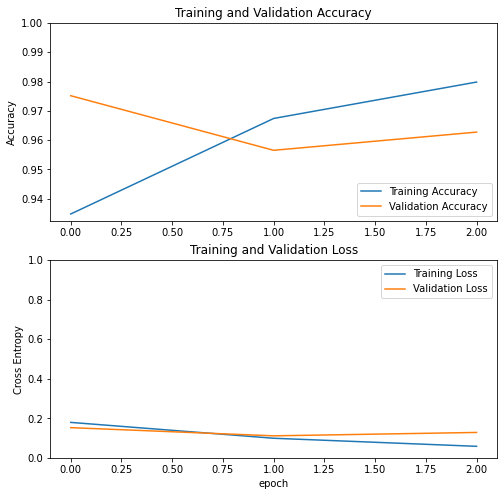

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import random

Images_test = image_dataset_from_directory("Alle_Bilder",
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')

prediction = model.predict(Images_test)
randindex = random.randint(0,len(Images_test))
# Die Funktion argmax() liefert uns den index des höchsten Werts des Ergebnisvektors
CNN = prediction[randindex].argmax()
plttitle = "Testbild Nr. {} \n CNN Klasse: {}".format(randindex,CNN)
plt.imshow(test_images[randindex].reshape(100,100), cmap='gray')
plt.title(plttitle)
plt.axis('off')
plt.show()

In [45]:
import numpy as np
import cv2

"""img = cv2.imread('foe.jpeg')
img = cv2.resize(img,(150,150))
img= np.expand_dims(img, axis=0)"""



Images_test = image_dataset_from_directory("Alle_Bilder",
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')
prediction = model.predict(img)

In [53]:
from PIL import Image
import numpy as np
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = cv2.resize(np_image, (150, 150))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('kz2.jpeg')
model.predict(image)

array([[0.32933655, 0.3284506 , 0.3422129 ]], dtype=float32)

In [56]:
image = load('foe2.jpeg')
model.predict(image)

array([[0.32984054, 0.33077112, 0.3393883 ]], dtype=float32)